## Homework 8
*Author: Puri Rudick*


In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
movies = {
    'Thor: Love and Thunder': 'tt10648342',
    'Top Gun: Maverick': 'tt1745960',
    'Jurassic World Dominion': 'tt8041270',
    'The Batman': 'tt1877830',
    'The Man from Toronto': 'tt11671006'
}

In [3]:
def get_movie_reviews(movies, movie_tt):
    url_text = 'https://www.imdb.com/title/' + movie_tt
    url = (url_text + "/reviews/_ajax?ref_=undefined&paginationKey={}")
    key = ""
    data = {"movie_name":[], "review_title": [], "review_txt": []}

    for i in range(0,10):
        response = requests.get(url.format(key))
        soup = BeautifulSoup(response.content, "html.parser")
        # Find the pagination key
        pagination_key = soup.find("div", class_="load-more-data")
        if not pagination_key:
            break

        # Update the `key` variable in-order to scrape more reviews
        key = pagination_key["data-key"]
        for title, review in zip(soup.find_all(class_="title"), soup.find_all(class_="text show-more__control")):
            data["movie_name"].append(movies)
            data["review_title"].append(title.get_text(strip=True))
            data["review_txt"].append(review.get_text())

    review = pd.DataFrame(data)
    return review


In [4]:
df = pd.DataFrame()
for m in movies:
    review = get_movie_reviews(m, movies[m])
    df = pd.concat([df, review])

#### Vectorize Reviews using TF-IDF

In [5]:
reviews = df['review_txt'].values.astype('U')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(stop_words = 'english')     #stop_words, ngram_range = (1,1))#transform
reviews_vec = tfv.fit_transform(reviews)           #returns a list of words.

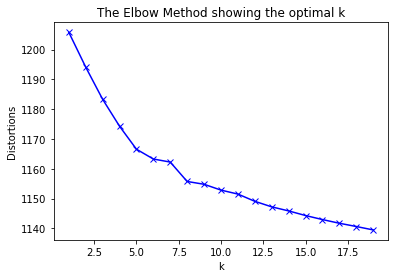

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = reviews_vec
K = range(1,20)

distortions = []
for k in K: 
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    kmeans.fit(X) 
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

```
The elbow method plot above shows distortions that is slightly straight line but shows a bit of convergeance around 6, 9, and 16 so these will be the values of k that we will be using in this Homework.
```

#### Create a function to fit k-Mean model, to print top 10 common words from each cluster, and to plot wordcloud for each cluster.

In [8]:
from wordcloud import WordCloud

def wordcloud_plt(k, subplt_row, subplt_col):
    model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    model.fit(X)
    col_name = 'cluster_k' + str(k)
    df[col_name] = model.labels_

    print("Top words per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    words = tfv.get_feature_names_out()

    for i in range(k):
        print('Cluster', i , ': ' + ', '.join(words[ind] for ind in order_centroids[i, :10]))
        
    fig,axs = plt.subplots(subplt_row, subplt_col, figsize = (40,15))
    h, v = 0, 0

    for i in range(k):
        s = df[df[col_name] == i]
        text = s['review_txt'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        axs[h, v].imshow(wordcloud, interpolation="bilinear")
        axs[h, v].set_title('Cluster: {}'.format(i))
        axs[h, v].axis('off')
        if v == subplt_col-1:
            h += 1
            v = -1
        v += 1
    plt.tight_layout

### k = 6

Top words per cluster:
Cluster 0 : kevin, hart, woody, harrelson, funny, movie, comedy, just, toronto, good
Cluster 1 : batman, movie, dark, riddler, pattinson, like, film, long, robert, bruce
Cluster 2 : movie, jurassic, film, dinosaurs, just, like, good, characters, original, world
Cluster 3 : maverick, gun, cruise, tom, movie, film, original, sequel, action, great
Cluster 4 : movie, marvel, thor, waste, just, money, bad, like, time, movies
Cluster 5 : thor, bale, movie, christian, thunder, mcu, waititi, love, taika, ragnarok


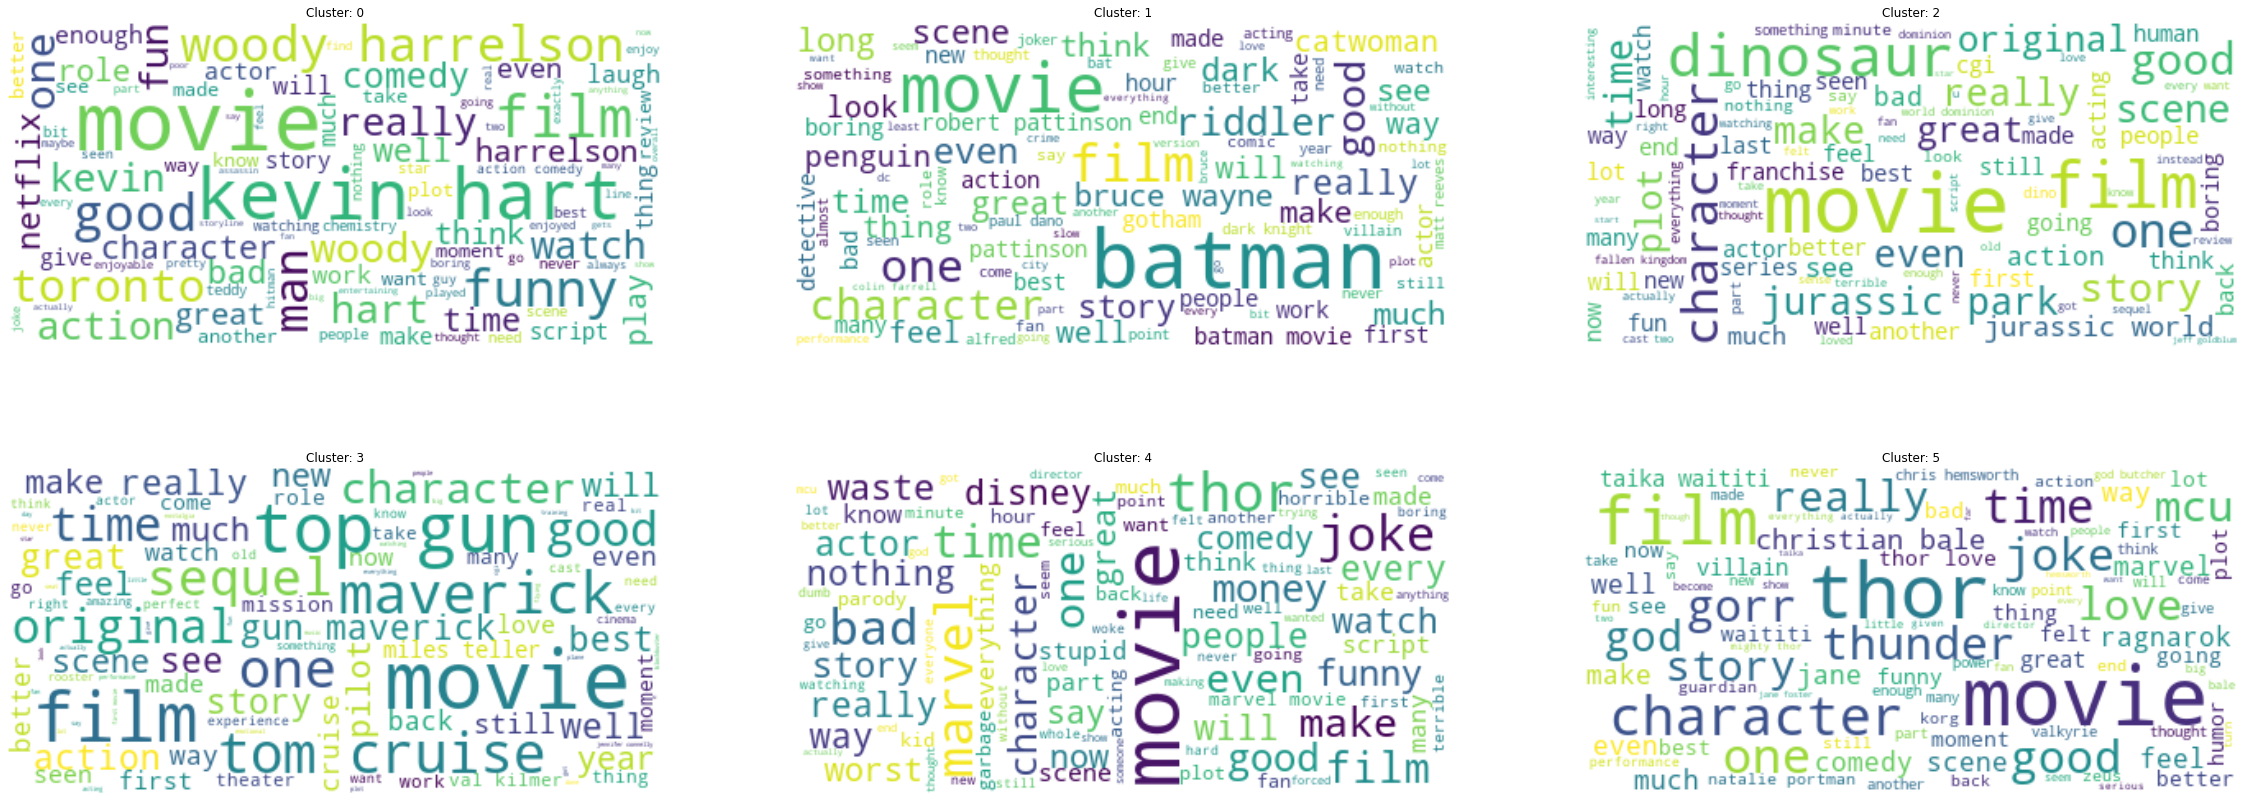

In [9]:
wordcloud_plt(6, 2, 3)

### k = 9

Top words per cluster:
Cluster 0 : kevin, hart, woody, harrelson, funny, movie, just, like, toronto, netflix
Cluster 1 : movie, dark, batman, slow, watch, super, long, knight, hour, like
Cluster 2 : jurassic, dinosaurs, movie, world, park, film, just, like, dominion, characters
Cluster 3 : thor, marvel, movie, jokes, bale, mcu, like, christian, thunder, film
Cluster 4 : hart, kevin, harrelson, movie, woody, comedy, night, watch, good, action
Cluster 5 : batman, movie, riddler, pattinson, film, like, dark, robert, just, bruce
Cluster 6 : maverick, gun, cruise, tom, film, original, sequel, mission, movie, action
Cluster 7 : movie, great, cruise, original, tom, action, gun, film, just, sequel
Cluster 8 : movie, bad, just, film, like, good, waste, money, actors, time


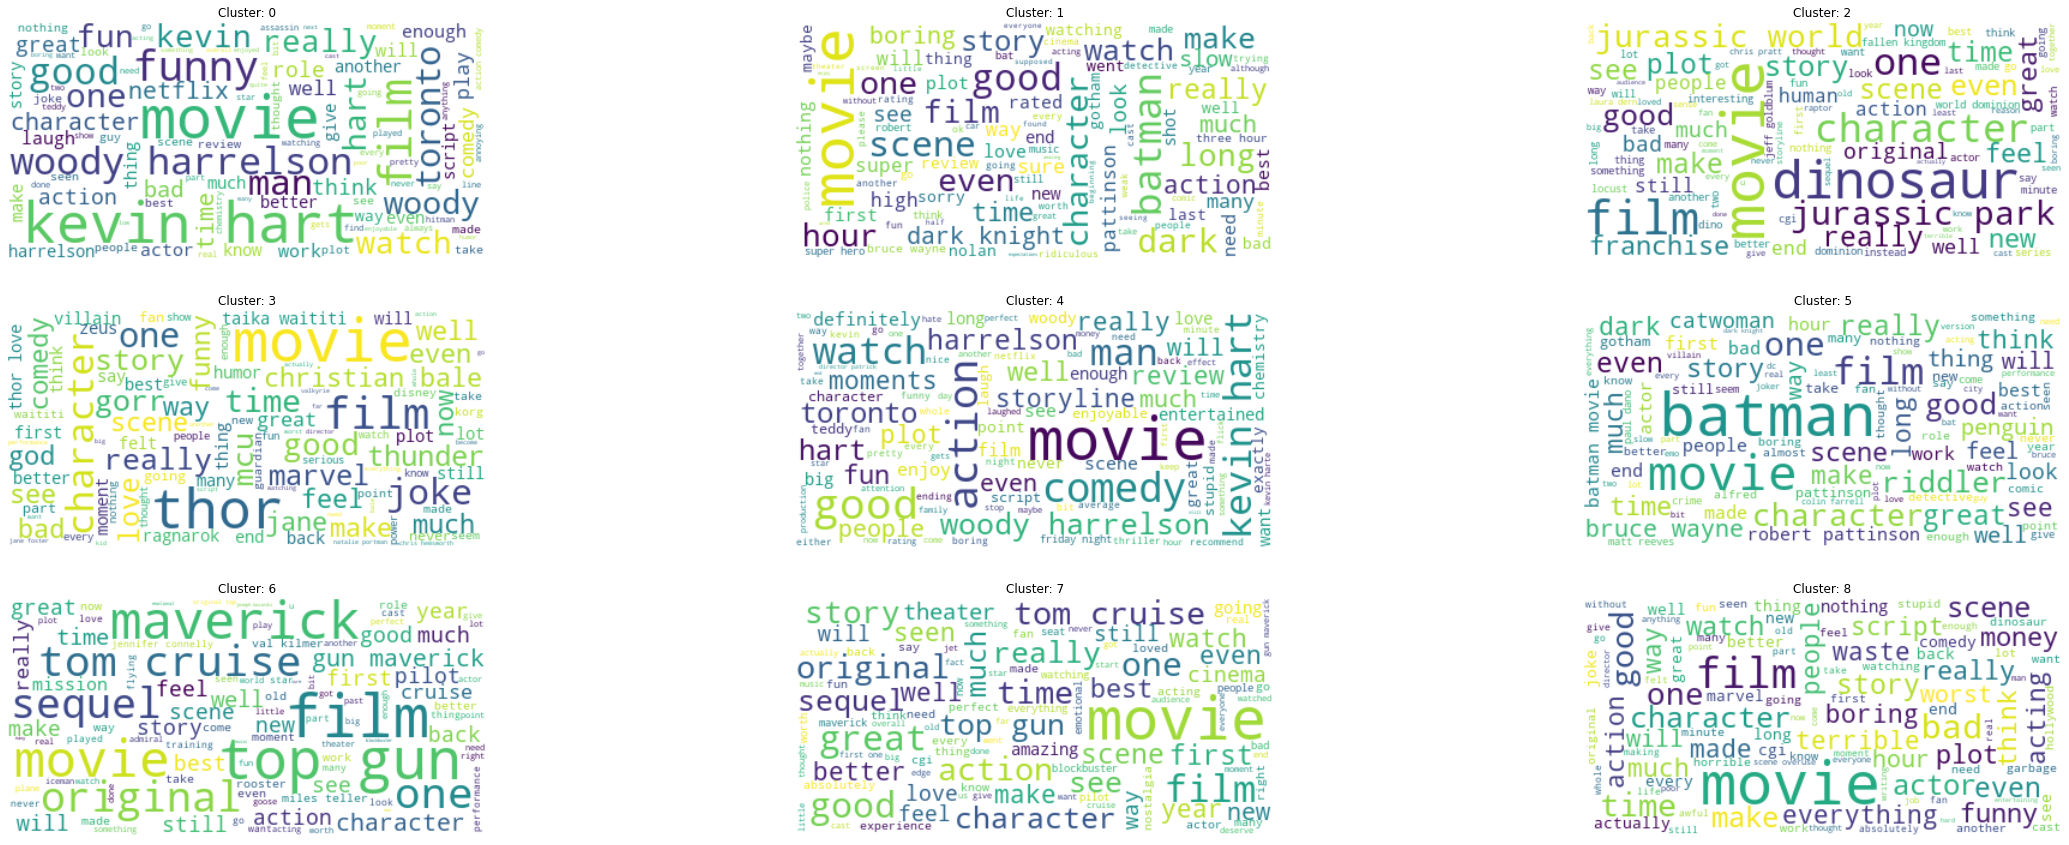

In [10]:
wordcloud_plt(9, 3, 3)

### k = 16

Top words per cluster:
Cluster 0 : funny, kevin, woody, hart, harrelson, like, movie, actor, johnson, dwayne
Cluster 1 : dark, movie, batman, knight, slow, make, good, rated, long, watch
Cluster 2 : movie, just, like, film, good, really, story, action, movies, boring
Cluster 3 : thor, movie, marvel, bale, christian, thunder, mcu, jokes, jane, love
Cluster 4 : night, harrelson, friday, hart, movie, exactly, watch, kevin, review, average
Cluster 5 : batman, movie, riddler, pattinson, film, like, dark, robert, bruce, just
Cluster 6 : maverick, gun, cruise, tom, film, teller, original, mission, sequel, miles
Cluster 7 : movie, best, seen, possible, experience, ve, original, loved, absolutely, cinema
Cluster 8 : terrible, movie, actors, acting, like, bad, script, mess, characters, just
Cluster 9 : hart, kevin, woody, harrelson, movie, comedy, like, just, action, funny
Cluster 10 : cruise, gun, tom, maverick, movie, film, original, action, sequel, good
Cluster 11 : waste, money, joke, marvel

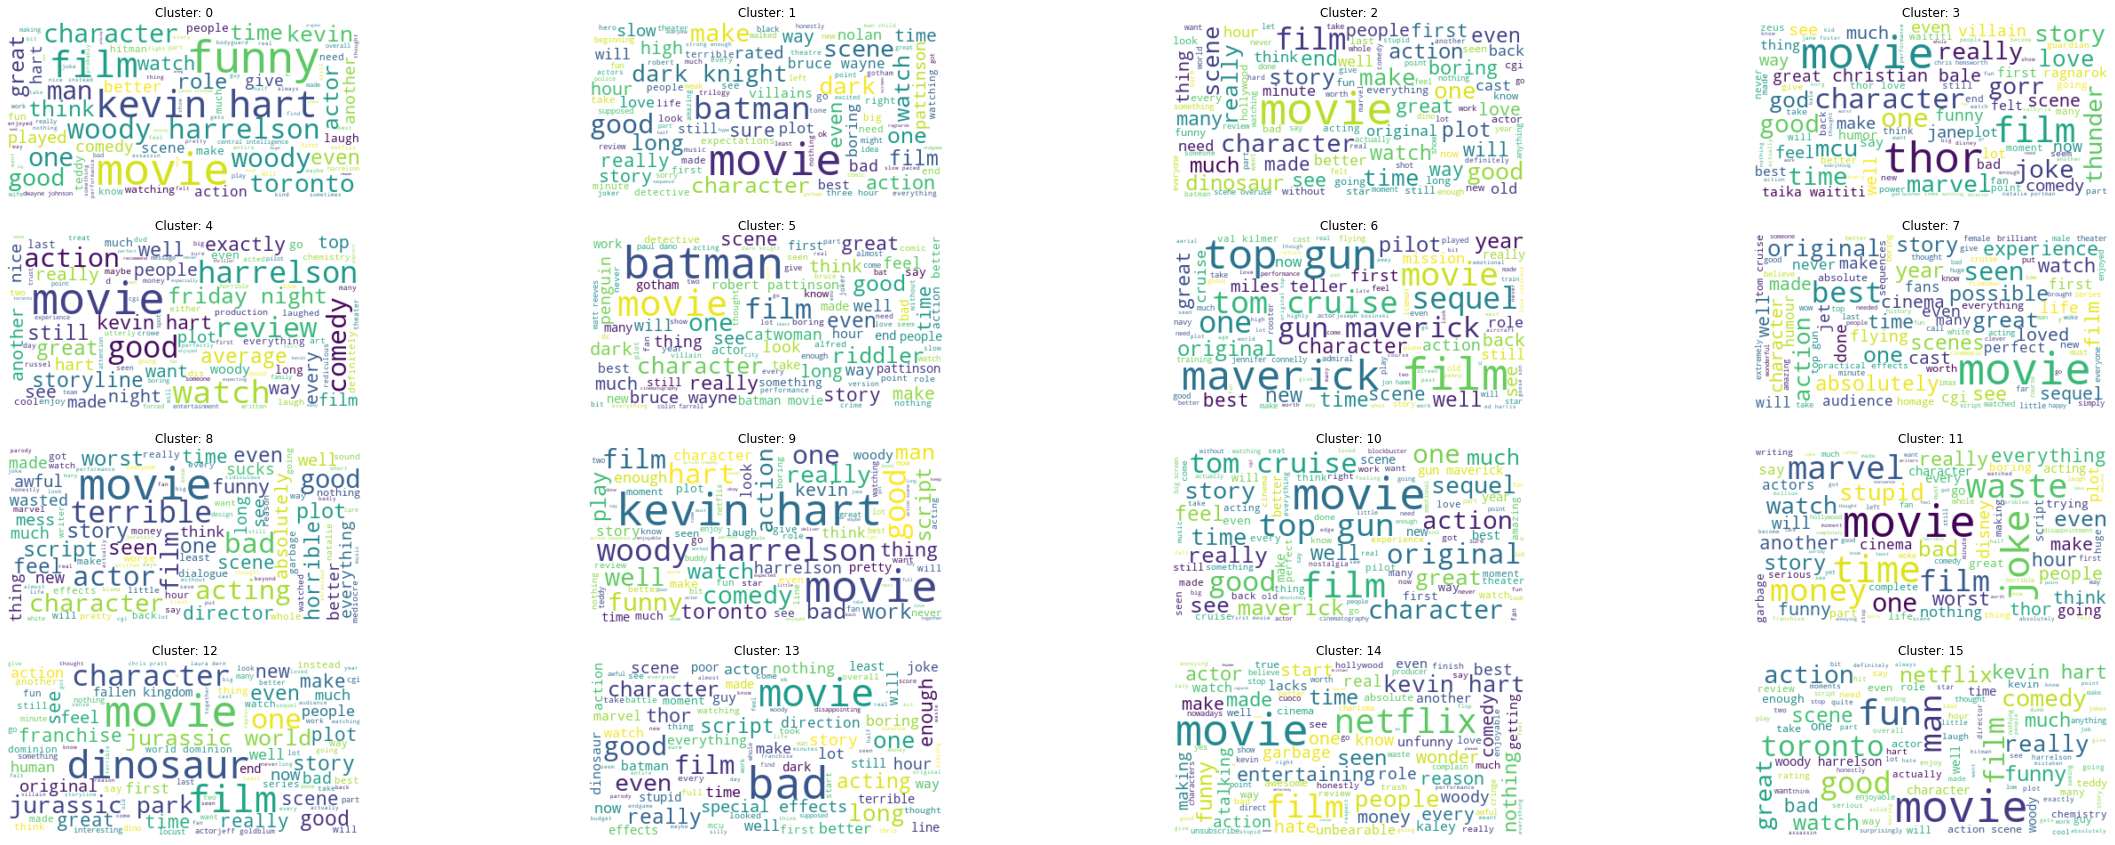

In [11]:
wordcloud_plt(16, 4, 4)

In [12]:
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  
0            3  
1            3  
2           13  
3           11  
4           11

---
Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference.<br> Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.


In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
# nltk.download('names')

sentiAnalyzer = SentimentIntensityAnalyzer()

In [14]:

sentiAnalyzer.polarity_scores('love')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}

In [15]:
polarityScore = []

for index, row in df.iterrows():
    score = sentiAnalyzer.polarity_scores(row['review_txt'])
    polarityScore.append(score['compound'])

In [16]:
df['polarity_score'] = polarityScore
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  polarity_score  
0            3          0.9722  
1            3         -0.9602  
2           13         -0.5991  
3           11          0.5267  
4           11          0.7991

---
2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

In [17]:
import seaborn as sns

def clusterScore(k):
    col_name = 'cluster_k' + str(k)
    cluster_Scores = df[[col_name,'polarity_score']]
    cluster_Group_Scores = cluster_Scores.groupby(col_name).agg({'polarity_score': ['mean', 'median', 'min', 'max']})
    print(cluster_Group_Scores)

    sns.set(rc={'figure.figsize':(40,12)})
    ax = sns.swarmplot(x=col_name, y='polarity_score', s=3, data=df)

### k = 6

           polarity_score                         
                     mean   median     min     max
cluster_k6                                        
0                0.367425  0.76780 -0.9941  0.9969
1                0.234004  0.73255 -0.9988  0.9995
2                0.284045  0.66290 -0.9985  0.9996
3                0.896784  0.97710 -0.8833  0.9998
4               -0.090004 -0.22750 -0.9942  0.9884
5                0.577301  0.90860 -0.9479  0.9993


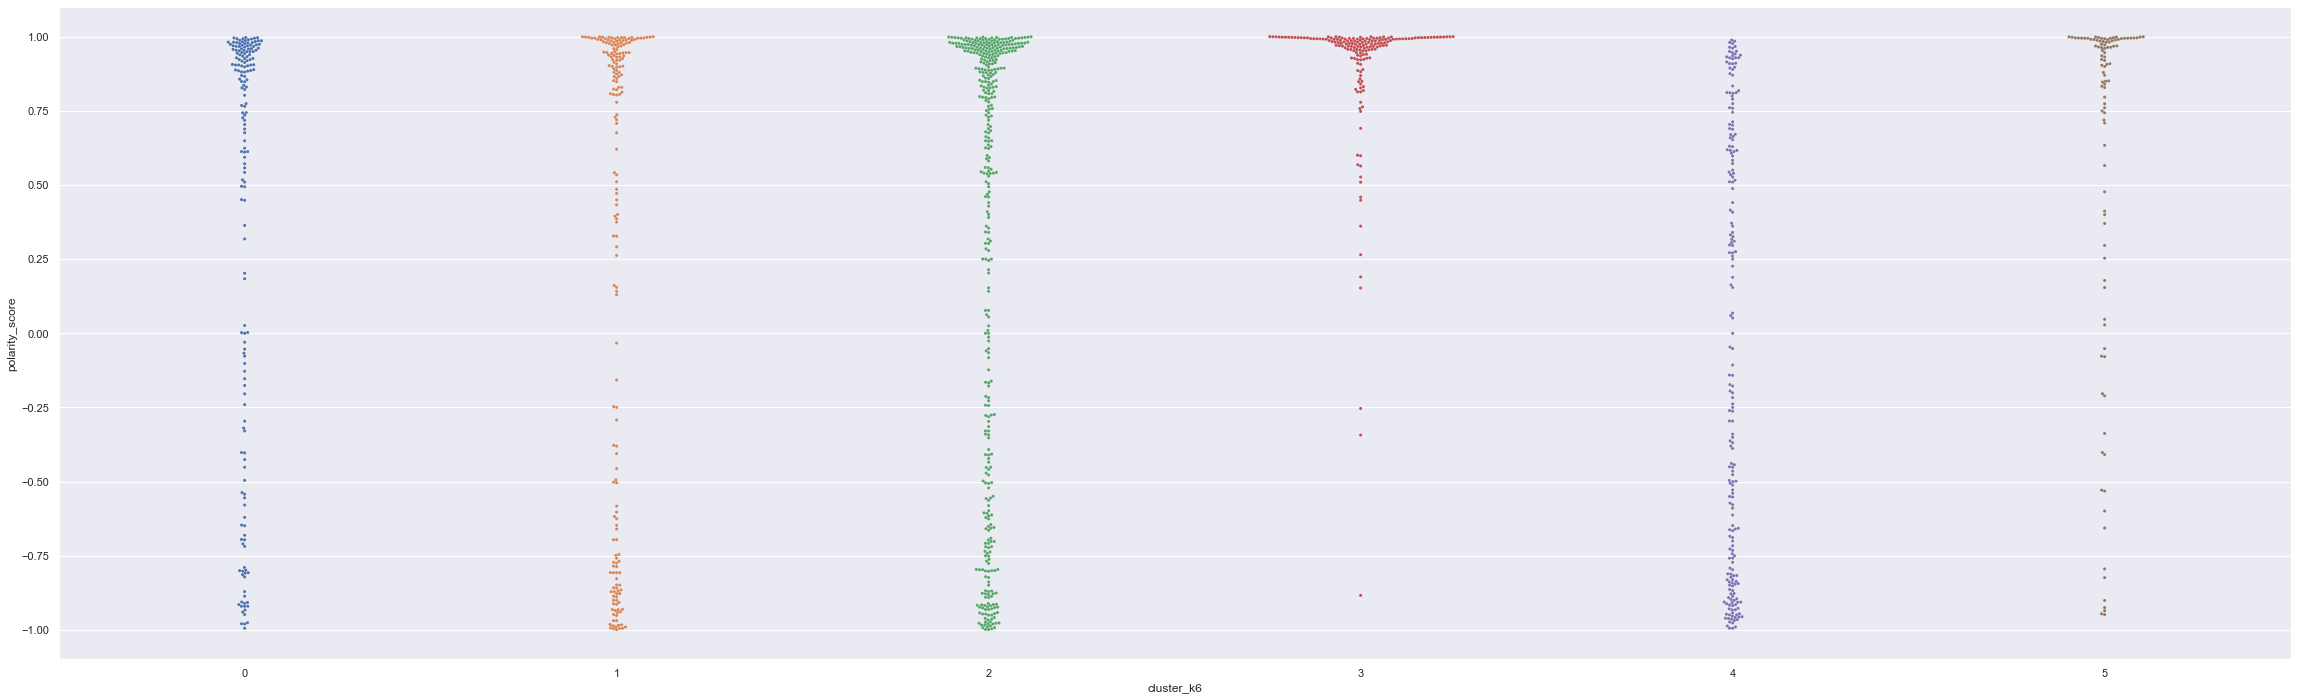

In [18]:
clusterScore(6)

> <br>For k=6, all clusters (except for Cluster #4) have mean polarity score > 0 which can be implied a positive sentiment. This is because of more positive terms, especially Cluster #3, in those clusters which clearly display on the swarmplot above.<br>
Cluster #4 is the only cluster that has mean polarity score < 0 (but really close to 0) and the swarmplot shows no majority of possitive or negative score.<br><br> 

### k = 9

           polarity_score                        
                     mean  median     min     max
cluster_k9                                       
0                0.384657  0.7880 -0.9798  0.9969
1                0.159987  0.3400 -0.9857  0.9914
2                0.238887  0.7183 -0.9985  0.9996
3                0.367154  0.7309 -0.9939  0.9993
4                0.321479  0.7037 -0.9941  0.9961
5                0.212919  0.8029 -0.9988  0.9995
6                0.929375  0.9867 -0.8833  0.9998
7                0.812286  0.9595 -0.9066  0.9990
8                0.001822  0.0000 -0.9942  0.9953


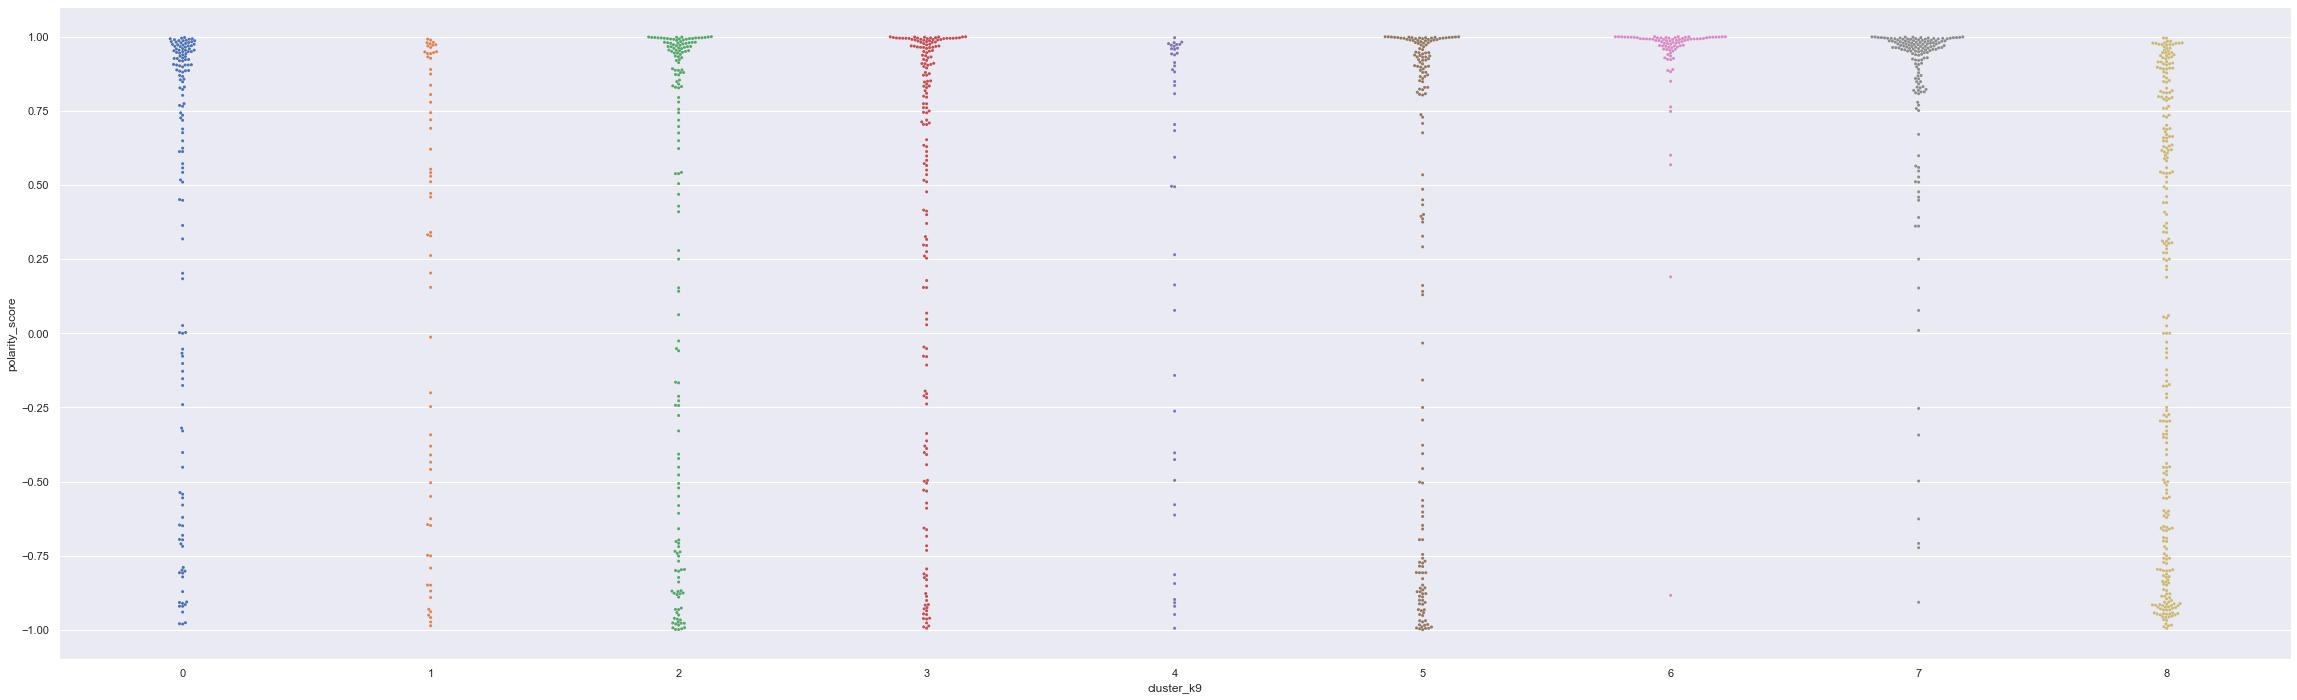

In [19]:
clusterScore(9)

> <br>For k=9, all clusters have mean polarity score > 0. However, only Cluster #6 and #7 that have high possitive.<br><br>

### k = 16

            polarity_score                         
                      mean   median     min     max
cluster_k16                                        
0                 0.391807  0.74685 -0.9798  0.9945
1                 0.072262  0.26210 -0.9857  0.9879
2                 0.262175  0.59940 -0.9893  0.9985
3                 0.433820  0.79580 -0.9939  0.9993
4                 0.304225  0.90685 -0.9477  0.9778
5                 0.245124  0.80630 -0.9988  0.9995
6                 0.954984  0.99130  0.6003  0.9994
7                 0.674426  0.91000 -0.9066  0.9966
8                -0.254404 -0.61315 -0.9942  0.9144
9                 0.425169  0.76500 -0.9396  0.9896
10                0.887959  0.97515 -0.8833  0.9998
11               -0.129186 -0.35060 -0.9734  0.9669
12                0.272226  0.79460 -0.9985  0.9996
13               -0.320222 -0.56925 -0.9650  0.9773
14                0.001945 -0.02670 -0.9179  0.9610
15                0.494711  0.90540 -0.9941  0.9969


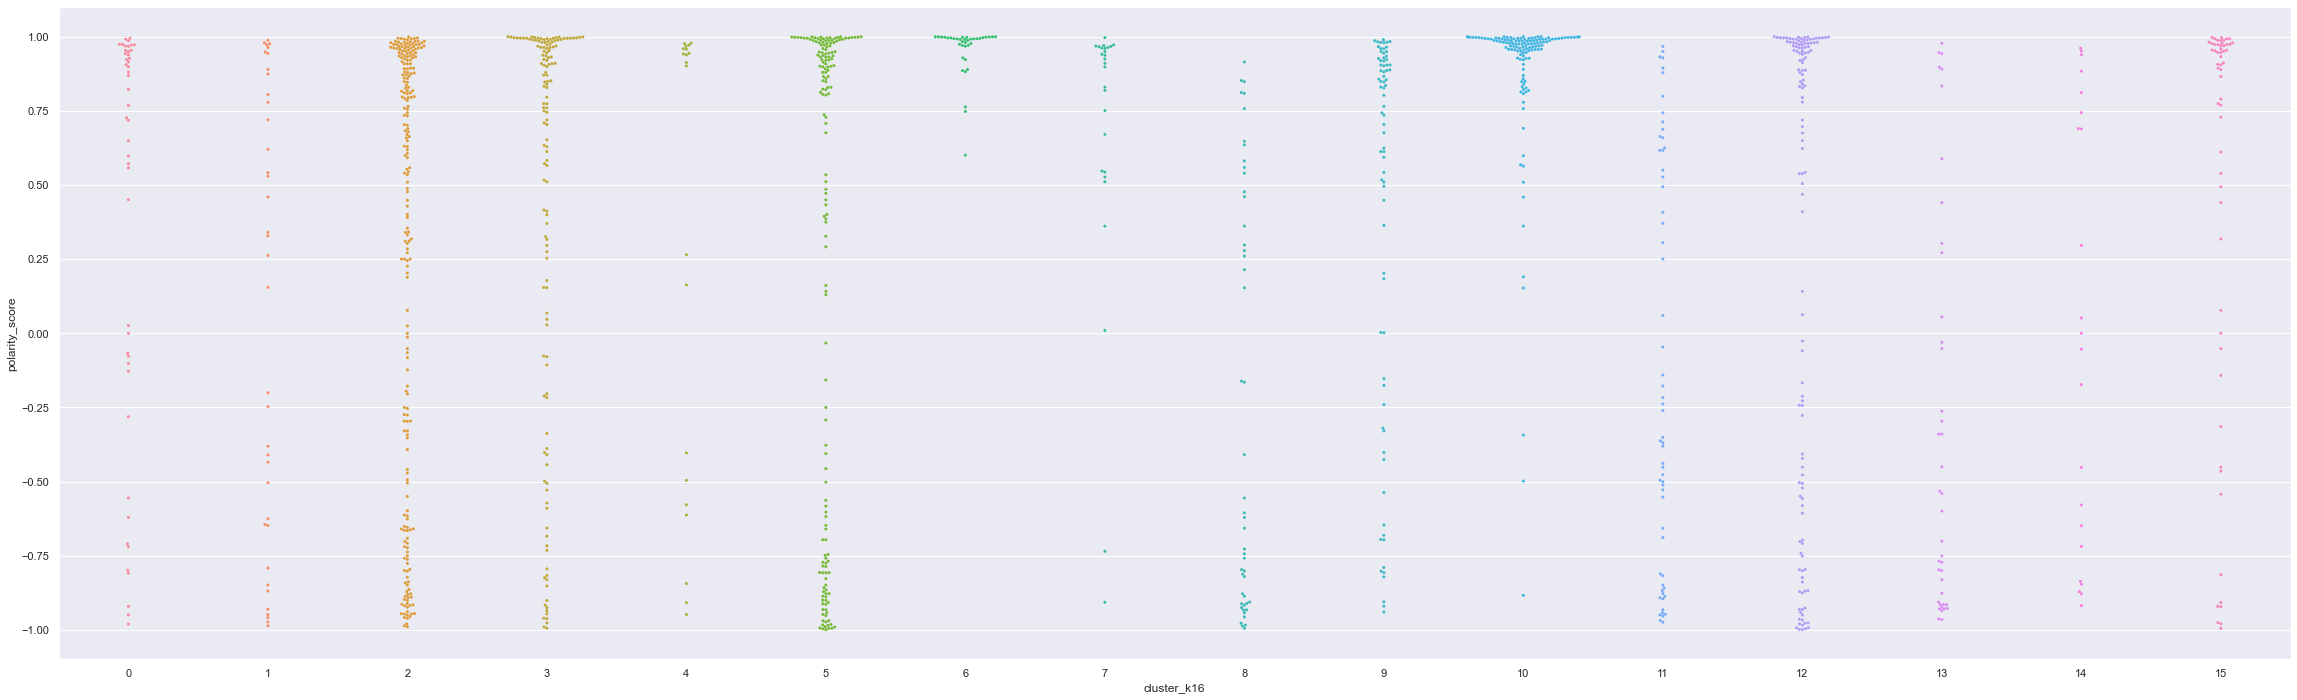

In [20]:
clusterScore(16)

> <br>For k=16, all clusters (except for Cluster #8, #11, and #13) have mean polarity score > 0 which can be implied a positive sentiment.<br>Cluster #6 and #10 that have high possitive.<br><br> 

---
3.	For extra credit, analyze sentiment of chunks as follows:
    - Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).
    - Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 


In [21]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

def getMovieReviewTags(reviewSentence):	
    nps = []
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(reviewSentence)

    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = ' '.join(word for word, tag in t.leaves())
            nps.append(t)
    return nps


def processReviewText(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    sentences = [getMovieReviewTags(sent) for sent in sentences]
    return sentences


grammar = r'''
     NP: {<DT|PP\$>?<JJ>*<NN>}  
         {<NNP>+}               
         {<NN><NN>}               
    '''

df['proc_review'] = df['review_txt'].apply(processReviewText)
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  polarity_score  \
0            3          0.9722   
1            3         -0.9602   
2           13         -0.5991   
3           11          0.5267   
4           11          0.7991   

                                         proc_review  
0  [[Thor, Love, Thunder, love, loss, whilst, Mig...  
1  [[SNL-esque, the full length, the movie, the f...  
2  [[Bale, Russell Crowe, a good moment, Hemswort...  
3  [[Disney, everything], [the point, spending, t...  
4  [[a huge marvel, fanboy, anything, MCU, a huge...

In [22]:
grammar = """
    NP:    {<DT><WP><VBP>*<RB>*<VBN><IN><NN>}
           {<NN|NNS|NNP|NNPS><IN>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS><CC>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS>+}
    """   
df['proc_review2'] = df['review_txt'].apply(processReviewText)
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  polarity_score  \
0            3          0.9722   
1            3         -0.9602   
2           13         -0.5991   
3           11          0.5267   
4           11          0.7991   

                                         proc_review  \
0  [[Thor, Love, Thunder, love, loss, whilst, Mig...   
1  [[SNL-esque, the full length, the movie, the f...   
2  [[Bale, Russell Crowe, a good moment, Hemswort...   
3  [[Disney, everything], [the point, spending, t...   
4  [[a huge marvel, fanboy, anything, MCU, a huge...   

                                        proc_review2  
0  [[Thor, Love and Thunder, themes of love, loss...  
1  [[SNL-esque, full length, movie, film, comedy]...  
2  [[Christian Bale, Russell Crowe, good moment, ...  
3  [[Disney, everything], [point, spending, time,...  
4  [[marvel fanboy, anything, MCU, huge letdown],...

In [23]:
def sentiment_scores(sentence,printScores=True): 
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    if (printScores):
        print("Overall sentiment dictionary is : ", sentiment_dict) 
        print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
        print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
        print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
        print("Sentence Overall Rated As", end = " ") 

        if sentiment_dict['compound'] >= 0.05 : 
            print("Positive") 
  
        elif sentiment_dict['compound'] <= - 0.05 : 
            print("Negative") 
  
        else : 
            print("Neutral") 

    return sentiment_dict['compound']


def chunkedSentimentScores(reviewChunk,printScores=False):
    termList = []
    scoreList = []
    
    for terms in reviewChunk:
        for term in terms:
            termStr = ' '.join(term)
            sent_score = sentiment_scores(termStr,printScores)

            if sent_score >= 0.05 : 
                termList.append(termStr)
                scoreList.append(sent_score)
            elif sent_score <= - 0.05 : 
                termList.append(termStr)
                scoreList.append(sent_score)

    return termList, scoreList

In [24]:
reviews, scores = chunkedSentimentScores(df['proc_review2'].tolist())

sentimentScore = pd.DataFrame({'User_Review': reviews, 'Sentiment_Score': scores})

pd.options.display.max_colwidth=500
sentimentScore.head()

User_Review  \
0                                                            Thor Love and Thunder themes of love loss whilst Mighty Thor Thor journey self discovery   
1                                                            rushed pace and way many jokes funny.Chris Hemsworth Thor extreme goofiness little stale   
2                                                                      Natalie Portman character Tessa Thompson Valkyrie Waititi welcome as Korg time   
3  Christian Bale MCU villains good motivation unsettling presence screen time.Takia direction other hand nice visual imagery colour palette MCU grey   
4                                                                                    CG start music by Michael Giacchino new theme lack of Thor theme   

   Sentiment_Score  
0           0.7964  
1           0.2500  
2           0.4588  
3           0.7269  
4          -0.3182

### Top 10 Possitive Sentiment Score

In [25]:
sentimentScore.nlargest(10, 'Sentiment_Score')

User_Review  \
1281  year wait years in amongst Covid-19 pandemic cinemas business sequel action thriller Top Gun form Maverick.A follow-up director Joseph Kosinski star Tom Cruise expectations water return world pilot extraordinaire Captain Pete Maverick Mitchell confident loner death friend changing world kind of pilot changing landscape man homages past die-hard fans era Top Gun new characters Mitchell world story adrenaline rush film eyeballs Maverick act pure entertainment thrills and heart nothing story ve...   
733                                                                                                                                         Thor Ragnarok improvement predecessors films Ragnarok director Taika Waititi type of humor new film Waititi Oscar win Jojo Rabbit success of comedy series Shadows creative freedom comedy silliness.The film momentum jokes halfway use goats time times film Hemsworth Natalie Portman SNL skit acting top.On other hand elements villain Christian Bale screen time extend   
2036                                                                                                                                                                                                                                                                                                                                                                                                                                         Great music great cinematography great acting great plot values in life love   
4708  one dollar Netflix action comedy Man from Toronto anything low expectations buddies film tiresome project talents main duo comedic goodness Patrick Hughes career as director hire breakout Red Hill director action escapades Hitman Bodyguard Toronto promise Kevin Hart looks coldness of Woody Harrelson brief moments Hughes numbers way hour runtime gas finish set-up Hart New York struggler Teddy romantic getaway bloodthirsty hitman Man from Toronto Harrelson Toronto way scenario attempts anythin...   
3783                                                                                                                                                                                                                                                                                                                         bonding scene.Batman selina romance feels forced.Batman careless sense theme cant stop star wars sounds like robert deniro Pattinson great batman ok batman great robinbatman symbol of hope   
1262                                                                                                                                                                                                                                                                                                                                                                                                       follow many films follow ups case great movie.All Tom Cruise perfectionist side great music great story superb   
4748                                                                                                                                                                                                                                                                                               movie cast of actors fun script comedic tone.The actors incredible job good combination fun sort road trip movie satirical black comedy vein of Tarantino.Definitely fans likes of Quentin Tarantino Guy Ritchie likes   
3040                                                                                                                                                                                                                                                                                                                                                                                                      HOW GREAT THE ORIGINAL WAS o

> <br>Looking at **Top 10 Possitive Sentiment Score**, we can see that there are a lot of possitive individual words in each review.<br><br> 

### Top 10 Negative Sentiment Score

In [26]:
sentimentScore.nsmallest(10, 'Sentiment_Score')

User_Review  \
278                                                                                                                                                       loser.Then boredom screaming goats minutes ages time themes loss and death terminal cancer inevitable loss cheap gag seconds that.This film year ADHD   
937                                                                                                                                                     Bad jokes bad pacing bad characters bad soundtrack single artist playing bad references bad time.I character serious boost new lease somehow thor movie   
2483                                                                                                                                                                   shady bad guys bad stereotypes plane crash fight with dinosaurs city Anybody T-Rex in San Diego Lost World mouths terrible sequence film   
2888                                                               sense.Raptor woman next scene same raptor car.Laser raptors lame dumb idea Fallen Kingdom.Unnecessary side characters evil lady gaga discount woman pilot woman cringy personality dodgson assistant guy development.Primary villain Dodgson   
3874                                                                                                                                                                                                             message movie real enemy people misunderstood criminals and Batman anything crime part problem   
3886               addition final hour Riddler Kevin Spacey SEVEN .Batman Riddlers Riddlers scale plan accidental aid Paco from Ash Vs Evil Dead crime scene weapon reason carpenter tool Bats carpet password Ridler post hours point Gotham impact Mayor Victory gathering refuge center Gotham Square Garden   
2901                                                                                                                                                                                                               Terrible story terrible CGI cheesy as hell total betrayal Jurassic World films Jurassic Park   
4014                   action film Bond-MIB film John Wick racing ones cop movie ones drug den A evening .... nothing .... As everyone emo kid batman .. brooder stone wall batman cancer throat batman Tumor movie Kick ass blob of fat riddler sort Bomb suit demented psychopathic genius Gotham series ....   
4854  director Patrick Hughes dire action-comedy Man From Toronto Kevin Hart average-joe screw-up Jasmine Mathews incompetence hitman Woody Harrelsen clichéd dumb plot writers Robbie Fox Chris Bremner South American terrorists FBI rival hitmen Ellen Barkin Pierson Fode Mathews Kaley Cuoco Dodge Charger   
3613                                                                                                                           villains Gotham story evil and malice Batman hometown element of corruption background of Bruce Wayne father thumb of crime boss Carmine Falcone John Turturro .All performances   

      Sentiment_Score  
278           -0.9595  
937           -0.9501  
2483          -0.9493  
2888          -0.9485  
3874          -0.9413  
3886          -0.9403  
2901          -0.9393  
4014          -0.9287  
4854          -0.9287  
3613          -0.9231

> <br>Same thine as **Top 10 Nossitive Sentiment Score**, we can see that there are a bunch of negative individual words in each review.<br><br> 